In [ ]:
%pip install --upgrade --quiet pypdf langchain-core langgraph langchain_openai langchain_anthropic langchain-community scikit-learn bs4 tavily-python

### Lesson 1: Context and Setup

We'll build a research assistant that combines 3 themes: 

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are more refined tools for decision-making. Reports can save costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace knowlege work. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously research about a topic from different angles.

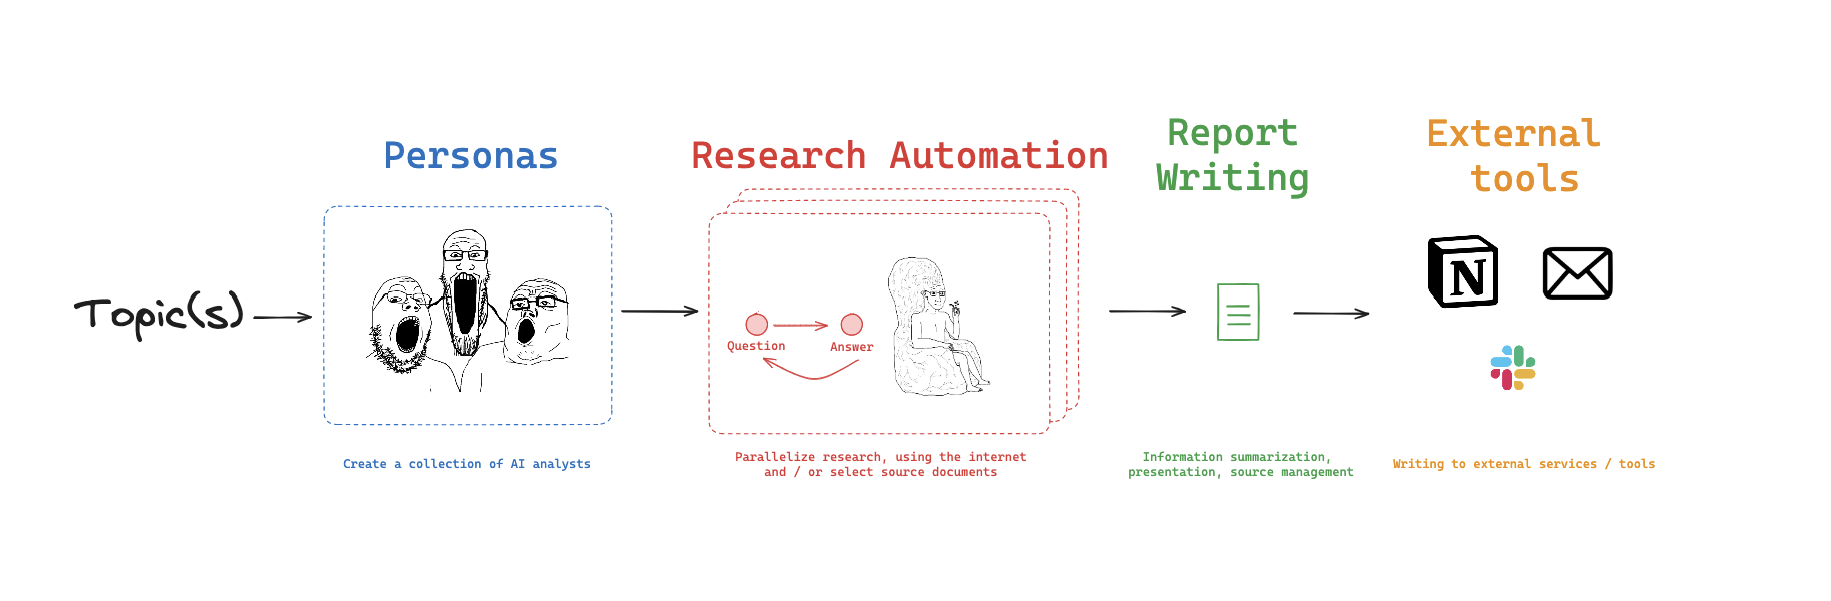

Let's specify an overall topic.

In [1]:
# Topic
topic = "Technical innovations related to the Meta LLlama3.1 LLM"

#### Personas

Next, we want to create our analyst personas. 

Here, we have some options:

1. Prompt an LLM with a few specific themes

2. Let an LLM choose the specifics based upon some provided context

We choose option 2. We have many options for adding context here to guide the process. 

This can include comments from localLLaMA reddit posts or from Zuck's blog post.
 
The idea here is that we use context to select more specific and interesting focus ares for our analysts. 

In [3]:
from langchain_community.document_loaders import WebBaseLoader

url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT = WebBaseLoader(url).load()

Data model for our analysts.

In [4]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

State for our research agent.

`ResearchGraphState` will be the overall state for our assistant.

`InterviewState` will be the state for each specific interview between each AI analyst and AI expert.

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    analysts: List[Analyst]
    interviews: Annotated[list, operator.add] 
    reports: Annotated[list, operator.add] 
    final_report: str
    analyst_feedback: str 
    editor_feedback: str 

Generate our analysts.

In [ ]:
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

Choose our LLM.

We can select any [chat model that support tool use](https://python.langchain.com/v0.1/docs/integrations/chat/)!

In [7]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

Now, we can create our set of research analysts.

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, HumanMessage

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI analyst personas. 
            
            Follow these instructions carefully:

            1. First, review the research topic:
            
            {topic}
            
            2. Examine any documents that have been optionally provided to guide creation of the analysts:
            
            {documents}

            3. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
            {analyst_feedback}  
            
            4. Determine the most interesting themes based upon documents and / or feedback above.
                        
            5. Pick the top {max_analysts} themes.

            6. Assign one analyst to each theme.""",
            
        ),
    ]
)

@as_runnable
def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    # Get topic and max analysts from state
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    analyst_feedback = state.get("analyst_feedback", "")

    # Generate analysts
    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": " ", 
                                                  "topic": topic, 
                                                  "analyst_feedback": analyst_feedback, 
                                                  "max_analysts": max_analysts})
    
    # Write the list of analysis to state
    return {"analysts": perspectives.analysts}

In [106]:
from pprint import pprint

# Feedback
analyst_feedback =  "Create analysts focused on (1) the training infrastructure, (2) the model architecture details, (3) the applications / use-cases for llama3.1"

# Test
initial_state = {"topic": topic, 
                 "analyst_feedback": analyst_feedback,
                 "max_analysts": 3}

perspectives = generate_analysts.invoke(initial_state)
for a in perspectives['analysts']:
    print("---")
    pprint(a.description)
    print("---")

---
('Dr. Carter focuses on the technical infrastructure required for training '
 'large language models like Meta LLama3.1. Her concerns include computational '
 'efficiency, scalability, and the environmental impact of training such '
 'models. She aims to optimize the training process to make it more '
 'sustainable and cost-effective.')
---
---
('Dr. Patel specializes in the architectural details of large language models. '
 'His focus is on the innovations in the design of Meta LLama3.1, including '
 'its layers, attention mechanisms, and optimization techniques. He is '
 'motivated by the quest to improve model performance and robustness.')
---
---
('Dr. Lee investigates the practical applications and use-cases of Meta '
 'LLama3.1. Her interests include how the model can be applied in various '
 'industries such as healthcare, finance, and education. She is driven by the '
 'potential societal impact and the ethical considerations of deploying such '
 'advanced AI models.')
---


#### Question-Asking

Now, we have a set of analysts!

Next, need to set up our interview between the analysts and expert.

Here is the state that we'll use to manage the interview:

* We'll use `Topic` to assumulate only unique documents

In [31]:
from langgraph.channels import Topic

class InterviewState(TypedDict):
    topic: str
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    editor_feedback: str
    # context: Annotated[list, operator.add]
    context: Annotated[list, Topic(typ=list, accumulate=True, unique=True)]
    interviews: list
    reports: list 

Let's set up a prompt for analysts to ask questions.

In [33]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

            Your goal is boil down to interesting and specific insights related to your topic.

            1. Interesting: Insights that people will find surprising or non-obvious.
            
            2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
            Here is your topic of focus and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona, and then ask your question.

            Continue to ask questions to drill down and refine your understanding of the topic.
            
            When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""",
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    
    # Write messages to state
    return {"messages": [result]}

In [11]:
# Starter message
messages = [HumanMessage(f"So you said you were researching {topic}?")]

# Analyst to test 
i = 0
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = generate_question.invoke(interview_state)
messages.extend(question['messages'])
messages

[HumanMessage(content='So you said you were researching Technical innovations related to the Meta LLlama3.1 LLM?'),
 AIMessage(content="Hello Alex, my name is Jordan, and I'm an analyst looking to gain some deep insights into the infrastructure required for training large language models like Meta LLlama3.1. I'm particularly interested in the innovations that help reduce training time and cost while boosting model performance. \n\nTo start, could you tell me about some of the most significant hardware advancements that have impacted the training of models like Meta LLlama3.1?", response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 267, 'total_tokens': 351}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-31d27b32-cc3c-46c3-a5e3-8eef99718b51-0', usage_metadata={'input_tokens': 267, 'output_tokens': 84, 'total_tokens': 351})]

#### Expert

Next, let's build an expert that can answer questions! 

Here, we can simply supply it with relevant context.

This context can come from:

* Web search
* Raw document
* A vectorstore
* Or other sources of interest

`Vectorstore`

Let's show how to build a simple vectorstore from a document.

In [34]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Load llama3.1 paper (pdf)
loader = PyPDFLoader("assistant/docs/llama3_1.pdf")
pages = loader.load_and_split()

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references, embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

Note that we can quickly and easily query our vectorstore.

Because we used the `load_and_split` method, each page embedded and indexed has metadata. 

This will be very useful later when we want to retain sources!

In [13]:
question = "training infrastructure (GPUs, networking) for llama 3.1"
docs = retriever.invoke(question)
docs[0].metadata

{'id': 'b2983c6c-a00e-4fb0-9416-51e39a82ca96',
 'source': 'assistant/docs/llama3_1.pdf',
 'page': 8}

We can format these docs with sources for answer generation.

In [14]:
formatted_retrieved_docs = "\n".join(
    [
        f'<Document source="{doc.metadata["source"]}" page="{docs[0].metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
        for doc in docs
    ]
)

`Web search`

Next, we'll show how to do web search.

[Tavily](https://tavily.com/) is a greap option for a web search tool, with fast and high quality results.

But free queries with Tavily are limited. `DuckDuckGoSearchAPIWrapper` is another easy option.

In [ ]:
_set_env("TAVILY_API_KEY")

In [14]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper

tavily_search = TavilySearchResults(max_results=4)

@tool
async def search_engine_tavily(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]

@tool
async def search_engine_ddg(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [16]:
search_docs = await search_engine_tavily.ainvoke(question)
search_docs[0]['content'][0:100], search_docs[0]['url'][0:100]

('The Llama 3.1 models were trained on over 15 trillion tokens on a custom-built GPU cluster with a to',
 'https://huggingface.co/blog/llama31')

We can format these docs with sources for answer generation.

In [61]:
formatted_search_docs = "\n".join(
    [
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ]
)

Now, let's test answer generation using this context. 

In [43]:
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert being interviewed by an analyst who focused on learning this topic: {topic}. 
            
            You goal is to answer a question posed by the interviewer.

            To answer question, use this context:
            
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context. 
            
            2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

            3. The context contain sources at the topic of each individual document.

            4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

            5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
            6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
            [1] assistant/docs/llama3_1.pdf, page 7 
            
            And skip the addition of the brackets as well as the Document source preanble in your citation.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]
   
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': context})  
    
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [ ]:
# Test
interview_state = {"analyst": perspectives["analysts"][i], 
                   "topic": topic,
                   "context": formatted_retrieved_docs+formatted_search_docs
                   "messages": messages}

answer = generate_answer.invoke(interview_state)
messages.extend(answer['messages'])
messages[-1].content[-100:]

Great! Now we have the ability to ask and answer questions.

Our next task is how to orchestrate the question-answer interactions. 

For this, we'll introduce a few ideas related to LangGraph controllability.

### Lesson 2: Parallelization

We saw that our expert can use different sources to answer questions.

What if we want to query [both our index of relevant context and web search](https://langchain-ai.github.io/langgraph/how-tos/branching/#parallel-node-fan-out-and-fan-in) in parallel.

This is supported in LangGraph!

#### Query Re-writing

First, recall we previously showed in Module 2 how to summarize content from a set of mesages. 

Let's use this to boil down our message history to high-quality search query that the expert will use to gather context.

In [44]:
# Get query for reflection
gen_search_query = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You will be given a conversation between an analyst and an expert. 

            Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
            
            First, analyze the full conversation.

            Pay particular attention to the final question posed by the analyst.

            Convert this final question into a well-structured query.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

# Schema 
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="The search query to use.")

# Query re-writing
query_gen_chain = gen_search_query | llm.with_structured_output(SearchQuery)

In [ ]:
search_query = query_gen_chain.invoke({'messages': messages})

#### Parallel search nodes

Now, let's build an interview graph.

We can set the number of turns of the interview that we want to allow.

In [37]:
# Max turns
max_num_turns = 3

Next, we can define nodes for search.

And, we'll lay out our graph.                

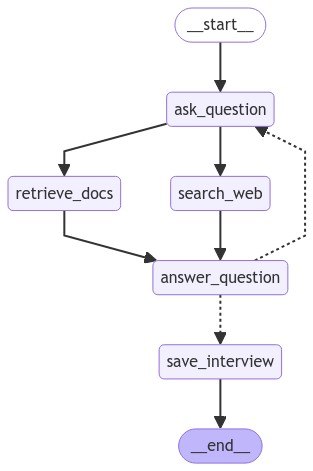

In [76]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import get_buffer_string

def retrieve_docs(state: InterviewState):
    """ Retrieve docs from vectorstore """

    # Get messages
    messages = state['messages']

    # Search query
    search_query = query_gen_chain.invoke({'messages': messages})

    # Retrieve
    docs = retriever.invoke(search_query.search_query)

    # Format
    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"context": [formatted_retrieved_docs]} 

def search_web(state: InterviewState):
    """ Retrieve docs from web search """

    # Get messages
    messages = state['messages']

    # Search query
    search_query = query_gen_chain.invoke({'messages': messages})

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interviews": [interview]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", END)

# Interview 
memory = SqliteSaver.from_conn_string(":memory:")
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [20]:
perspectives["analysts"][0]

Analyst(affiliation='OpenAI Research', name='Dr. Emily Carter', role='Training Infrastructure Specialist', description="Dr. Carter focuses on the technical infrastructure required for training large language models like Meta's Llama3.1. Her concerns include the computational resources, data pipelines, and optimization techniques necessary to efficiently train such models. She aims to identify bottlenecks and propose solutions to improve training efficiency and scalability.")

In [77]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

i = 0 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run
interview = interview_graph.invoke(interview_state, thread)

In [78]:
from IPython.display import Markdown
full_interview_state = interview_graph.get_state(thread).values["messages"]
Markdown(full_interview_state[-1].content)

Certainly, Alex. One notable example involves the mitigation of network load balancing issues during the training of Llama 3.1. 

### Case Study: Network Load Balancing

**Challenge**: During the training of Llama 3.1, the network load balancing was a significant bottleneck. Traditional methods like Equal-Cost Multi-Path (ECMP) routing were insufficient for handling the "fat" network flows produced by LLM training. This led to network congestion and inefficiencies, slowing down the overall training process [1].

**Mitigation Strategy**: To address this, Meta employed an enhanced collective library that creates multiple network flows between GPUs. Specifically, instead of creating just one network flow between two GPUs, the collective library creates 16 network flows. This approach reduces the traffic per flow and provides more paths for data transfer, thereby improving load distribution across the network [1].

**Impact**: This strategy significantly alleviated the network congestion issues. By distributing the data transfer load more evenly across multiple paths, the training process became more efficient. This improvement was crucial for maintaining high throughput and minimizing delays, especially given the scale of the training setup involving up to 16,000 H100 GPUs [1].

This example highlights how targeted optimizations in network load balancing can have a substantial impact on the efficiency and effectiveness of training large language models like Llama 3.1.

### Source
[1] assistant/docs/llama3_1.pdf, page 8

### Lesson 3: Sub-graphs

Great! Now we have an interview graph that uses parallelization to get documents from multiple sources.

Next, we'll introduce the idea of sub-graphs.

[Sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/) allow you to create parts of your graph that have their own state.

In particular, here we'll want to perform a few different interviews.

Each interview will have its own `InterviewState`.

So, we will have:

1. An outer state that collates information across all interviews, `ResearchGraphState`
2. An inner state for each interview, `InterviewState`.

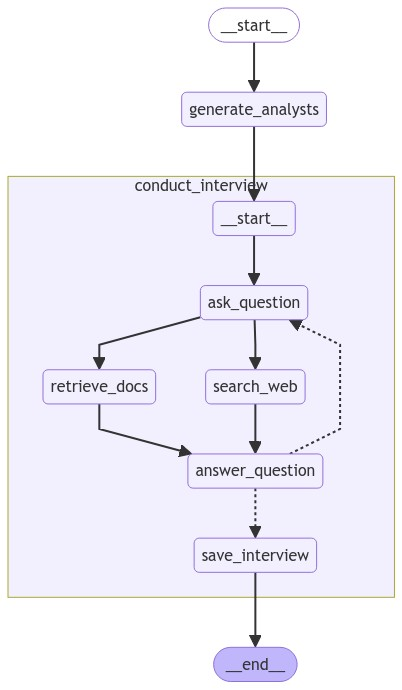

In [79]:
# Build the full graph
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_edge(START, "generate_analysts")
builder.add_edge("generate_analysts", "conduct_interview")
builder.add_edge("conduct_interview", END)
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Now, recall that:

1. We will generate a set of `analysts` in `generate_analysts`.
2. We will write those to the `analysts` key in `ResearchGraphState` 
3. The interview sub-graph will have access to each key in `ResearchGraphState`

But, we want to initite an interview for each analyst we created in the `analysts` list! 

So, we'll going to need to introduce a way to:

1. Initiate an interview for each analyst in `analysts`
2. Parallelize the interviews for efficiency

That brings us to our next concept! 

### Lesson 4: Map-Reduce

[Map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) is essential for efficient task decomposition and parallel processing. 

It involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.

LangGraph has support for this using the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) API!

All we need is one conditional edge to initiate an interview for each analyst.

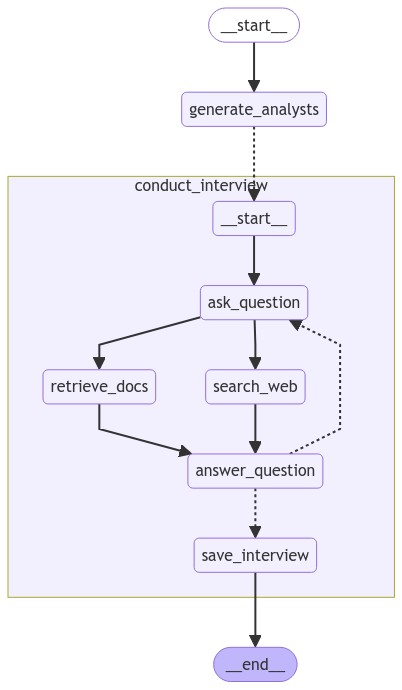

In [80]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    topic = state["topic"]
    return [Send("conduct_interview", {"analyst": analyst,
                                       "messages": [HumanMessage(
                                           content=f"So you said you were writing an article on {topic}?"
                                       )
                                                   ]}) for analyst in state["analysts"]]

# Build the full graph
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_edge(START, "generate_analysts")
### This is all we need to add! ### 
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", END)

# Compile
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Thread used for memory
thread = {"configurable": {"thread_id": "1"}}

# Initial state
initial_state = {"topic": topic, 
                 "analyst_feedback": "Make sure one analyst focuses on training infrastructure -- networking, # gpus, etc",
                 "max_analysts": 3}

# Run the graph 
for event in graph.stream(initial_state, thread, stream_mode="values"):
    print(event)

Great! We can see the LangSmith trace to show that we've parallelized each interview.

https://smith.langchain.com/public/a97532fe-075b-44d1-b931-97d88bd53ba3/r

### Lesson 5: Report writing

Great! We have actually finished most of the wiring of our assistant.

We now want to add one of the most fun parts, and also the most customizable. 

We want to summarize each interview into a report!

Let's define an LLM that we're use for report writing.

In [81]:
from langchain_anthropic import ChatAnthropic
report_writer_llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

Now, let's define a system prompt for distilling each interview and / or set of sources documents into a short report.

In [91]:
from langchain_core.output_parsers import StrOutputParser

report_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert technical analyst, writer, and editor. 
            
            Your task is to create a short, easily digestible report based on a set of source documents.

            1. Analyze the content of the source documents: 
            - The name of each source document is at the start of the document, with the <Document tag.
            
            2. Create a report structure using markdown formatting:
               - Use ## for the report title
               - Use ### for section headers
            
            3. Write the report following this structure:
               a. Title (## header)
               b. Summary (### header)
               c. Sources (### header)

            4. Make your title engaging based upon the focus area of the analyst: 
            {description}

            4. For the summary section:
            - Set up summary with general background / context related to description
            - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
            - Create a numbered list of source documents, as you use them
            - Do not mention the names of interviewers or experts
            - Aim for approximately 400 words maximum
            - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
            5. Incorporate editor feedback seamlessly into your report, if provided.
            
            6. In the Sources section:
               - Include all sources used in your report
               - Provide full links to relevant websites or specific document paths
               - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
               - It will look like:

                ### Sources
                [1] Link or Document name
                [2] Link or Document name

            7. Be sure to combine sources. For example this is not correct:

            [3] https://ai.meta.com/blog/meta-llama-3-1/
            [4] https://ai.meta.com/blog/meta-llama-3-1/

            There should be no redundant source. It should simply be:

            [3] https://ai.meta.com/blog/meta-llama-3-1/
            
            7. Final review:
               - Ensure the report follows the required structure
               - Include no preamble before the title of the report
               - Check that all guidelines have been followed""",
        
        ),
        ("human", """Here are the materials you'll be working with:

                        Overall focus on the analyst:
                        {description}
                        
                        Source documents retrieved from an interview w/ an expert:
                        {context}

                        Here is any editor feedback that should be incorporated into the report:
                        {editor_feedback}"""),
    ]
)

def generate_report(state: InterviewState):
    """ Node to generate report based upon interview """

    # State 
    topic = state["topic"]
    context = state["context"]
    analyst = state["analyst"]
    editor_feedback = state.get("editor_feedback", [])

    # Generate report
    report_gen_chain = report_gen_prompt | report_writer_llm | StrOutputParser()
    report = report_gen_chain.invoke({"description": analyst.description, 
                                      "context": context, 
                                      "topic": topic,
                                      "editor_feedback": editor_feedback})
    
    return {"reports": [report]}

Here, it is worth workshopping the report generation prompt. 

This is where there is considerable opportunity for customization.

I've found a few tricks:

1. Summarize each interview in isolation. This is better than trying to summarize all interviews into a single, larger report.
2. Summarize from the collection of sources elicited in the expert interview rather than the expert answers. 

Of course, you can play with both of these! 

In [88]:
# Get retrieved docs and full interview from state
all_retrieved_docs = interview_graph.get_state(thread).values["context"]
full_interview = interview_graph.get_state(thread).values["interviews"]

# Test
test_state = {"topic": topic, 
              "context": all_retrieved_docs,
              "analyst": perspectives['analysts'][0],}

# Run
report = generate_report(test_state)
Markdown(report['reports'][0])

## Scaling Up: Meta's Llama 3.1 Pushes the Boundaries of AI Infrastructure

### Summary

Meta's latest large language model, Llama 3.1, represents a significant leap forward in the scale and capabilities of AI systems [1]. At the heart of this advancement is the flagship 405B parameter model, which required unprecedented computational resources and infrastructure to train [2]. 

The training process for Llama 3.1 405B utilized up to 16,000 NVIDIA H100 GPUs, each running at 700W TDP with 80GB of HBM3 memory [3]. This massive GPU cluster was interconnected using a sophisticated network topology, including a three-layer Clos network with 400 Gbps interconnects between GPUs [3]. The storage infrastructure was equally impressive, with Meta's Tectonic distributed file system providing 240 PB of storage across 7,500 servers, capable of sustaining 2 TB/s throughput with peaks of 7 TB/s [3].

One of the key challenges in training at this scale was managing the power consumption fluctuations. The simultaneous power draw changes across tens of thousands of GPUs could result in instant fluctuations of tens of megawatts across the data center, pushing the limits of the power grid [4]. This highlights the growing intersection between AI development and energy infrastructure.

The training recipe for Llama 3.1 405B involved a three-stage process: initial pre-training, long-context pre-training, and annealing [5]. The initial pre-training used a cosine learning rate schedule with careful batch size adjustments to balance stability and efficiency [5]. The data mix was dynamically adjusted during training to improve performance on specific tasks, including increasing non-English data for better multilingual capabilities [5].

Interestingly, environmental factors played a role in training performance, with a observed 1-2% diurnal throughput variation due to higher mid-day temperatures impacting GPU dynamic voltage and frequency scaling [4].

The scale of Llama 3.1's training also necessitated new approaches to debugging and optimization. Meta developed tools to prioritize potentially problematic communications and identify stragglers that could slow down thousands of other GPUs [4].

Despite the massive scale of the Llama 3.1 405B model, Meta's research suggests that the performance improvements may be reaching a plateau. The IsoFLOPs curves become flatter around the minimum as the compute budget increases, indicating that performance is relatively robust to small changes in the trade-off between model size and training tokens [6].

This push to extreme scale in AI model training highlights both the incredible progress in the field and the growing challenges in terms of infrastructure, energy consumption, and optimization techniques required to continue advancing the state-of-the-art in large language models.

### Sources
[1] https://ai.meta.com/blog/meta-llama-3-1/  
[2] https://datasciencedojo.com/blog/meta-llama-3-1/  
[3] https://llamaimodel.com/requirements/  
[4] https://ai.meta.com/blog/meta-llama-3/  
[5] https://www.analyticsvidhya.com/blog/2024/07/meta-llama-3-1/  
[6] https://ai.meta.com/static-resource/july-responsible-use-guide

Good! I like this report. 

Now, we simply re-build our interview graph, `interview_builder`, with `generate_report`! 

So, we will generate each report at the end of the interview.

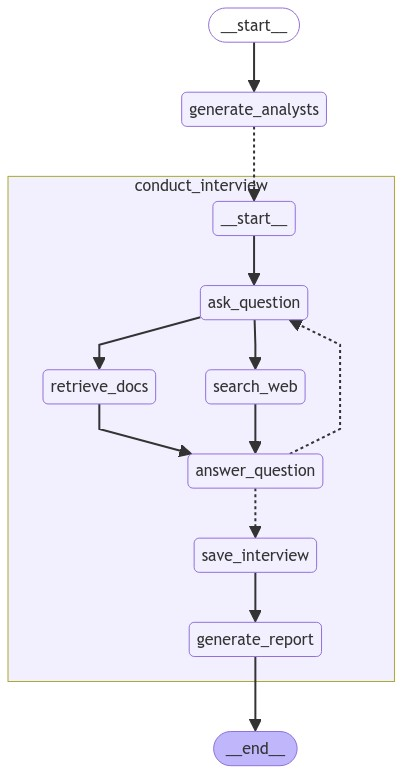

In [93]:
# Add nodes and edges for the interview
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("generate_report", generate_report)

# Interview Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "generate_report")
interview_builder.add_edge("generate_report", END)

# Build the full graph
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_edge(START, "generate_analysts")
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", END)

# Compile
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Thread used for memory
thread = {"configurable": {"thread_id": "2"}}

# Initial state
initial_state = {"topic": topic, 
                 "analyst_feedback": analyst_feedback,
                 "max_analysts": 3}

# Run the graph 
for event in graph.stream(initial_state, thread, stream_mode="values"):
    print(event)

### Lesson 6: Human In The Loop

Finally, let's include human in the loop! 

This is useful at least two places: 

1) We can use it to review the analysts. We can then review and / or modify the focus areas of the analysts that we created.
2) We can use it to approve actions, like writing to external services.

In this example, we created Slack webhook for writing the reports.

In [94]:
import os

# Web hook for Slack Channel
slack_bot_url = os.getenv('LANCE_BOT_SLACK_URL')

The below data model can be used to write your output to Slack, which uses [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 


In [95]:
from typing import Union

# Data model for Slack
class TextObject(BaseModel):
    type: str = Field(
        ..., 
        description="The type of text object, should be 'mrkdwn' or 'plain_text'.", 
        example="mrkdwn"
    )
    text: str = Field(
        ..., 
        description="The text content.",
        example="Hello, Assistant to the Regional Manager Dwight! ..."
    )

class SectionBlock(BaseModel):
    type: str = Field(
        "section", 
        description="The type of block, should be 'section'.", 
        const=True
    )
    text: TextObject = Field(
        ..., 
        description="The text object containing the block's text."
    )

class DividerBlock(BaseModel):
    type: str = Field(
        "divider", 
        description="The type of block, should be 'divider'.", 
        const=True
    )

class SlackBlock(BaseModel):
    blocks: List[Union[SectionBlock, DividerBlock]] = Field(
        ..., 
        description="A list of Slack block elements."
    )

Finally, we create two final nodes:

* `finalize_report` will combine the reports from each interview into a single document and write an introduction
* `write_report` send the report from each interview to Slack

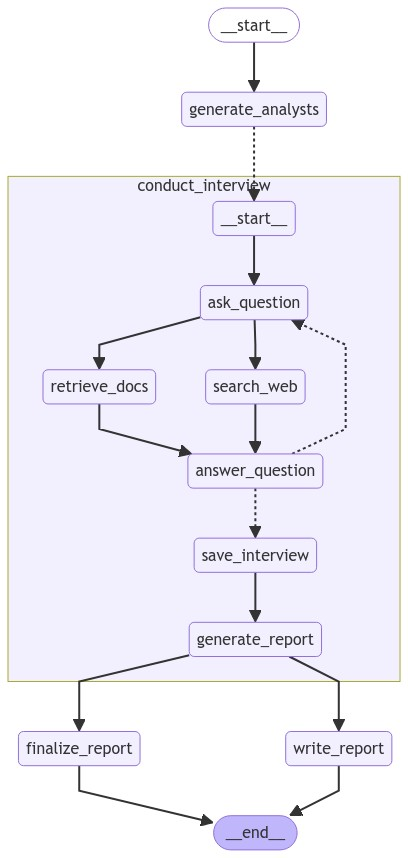

In [108]:
import time
import requests

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, and combine them """
    
    # Full set of interviews
    sections = state["reports"]

    # Combine them
    formatted_str_sections = "\n\n".join([f"{section}" for i, section in enumerate(sections, start=1)])

    # Write the intro
    final_report_gen_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """You are an expert analyst, writer, and editor. You will be given a full report.
    
                Write a crisp and compelling introduction for the report.

                Include no pre-amble for the introduction.
    
                Use markdown formatting. Use # header for the start along with a title for the full report.""",
            
            ),
            ("human", """Here are the interviews conducted with experts on this topic:
                            <sections>
                            {sections}
                            </sections>"""),
        ]
    )

    # Generate intro
    final_report_gen_chain = final_report_gen_prompt | report_writer_llm | StrOutputParser()
    report_intro = final_report_gen_chain.invoke({"sections": formatted_str_sections})

    # Save full / final report
    return {"final_report": report_intro + "\n\n" + formatted_str_sections}

def write_report(state: ResearchGraphState):
    """ Write the report to external service (Slack) """
    
    # Write to slack
    slack_fmt_promopt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """Your goal is to first analyze a short report, which is in markdown.
    
                Then, re-format it in Slack blocks so that it can be written to the Slack API.
    
                The section of the report will be: title, summary, sources.
    
                Make each section header bold. For example, *Summary* or *Sources*.
    
                Include divider blocks between each section of the report.""",
            
            ),
            ("human", """Here is the report to re-format: {report}"""),
        ]
    )

    # Full set of interview reports
    reports = state["reports"]

    # Write each section of the report indvidually 
    for section_to_write in reports:
    
        # Format the markdown as Slack blocks
        slack_fmt = slack_fmt_promopt | llm.with_structured_output(SlackBlock)
        slack_fmt_report = slack_fmt.invoke({"report": section_to_write})
        list_of_blocks = [block.dict() for block in slack_fmt_report.blocks]

        # Add a header
        true = True
        list_of_blocks.insert(0, {
            "type": "header",
            "text": {
                "type": "plain_text",
                "text": ":robot_face: Lance Bot has been busy ...",
                "emoji": true
            }
        })

        # Write to your Slack Channel via webhook
        headers = {
            'Content-Type': 'application/json',
        }
        data = {
            "blocks": list_of_blocks,
        }
        response = requests.post(slack_bot_url, headers=headers, json=data)

# Build the full graph
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("finalize_report", finalize_report)
builder.add_edge(START, "generate_analysts")
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "finalize_report")
builder.add_edge("write_report", END)
builder.add_edge("finalize_report", END)

# Compile
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory, interrupt_before=["generate_analysts", "write_report"])

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Thread used for memory
thread = {"configurable": {"thread_id": "3"}}

# Initial state
initial_state = {"topic": topic, 
                 "max_analysts": 3}

# Run the graph until the first interruption at the analyst generation step
for event in graph.stream(initial_state, thread, stream_mode="values"):
    print(event)

# Specify any analysts that you want to ensure we include
user_preference_analyst = input("Do you have any specific analyst personas that you want to include?")

# Update the state to include our feedback
updated_state = {"analyst_feedback": user_preference_analyst}
graph.update_state(thread, updated_state)

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

# Runs until we hit the final write report step
user_approval = input("Do you want to write the report to Slack? (yes/no): ")

if user_approval.lower() == "yes":
    # If approved, continue the graph execution to write to Slack
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Completed without writing to Slack")

Great! We can now see the reports written to Slack once we give approval.

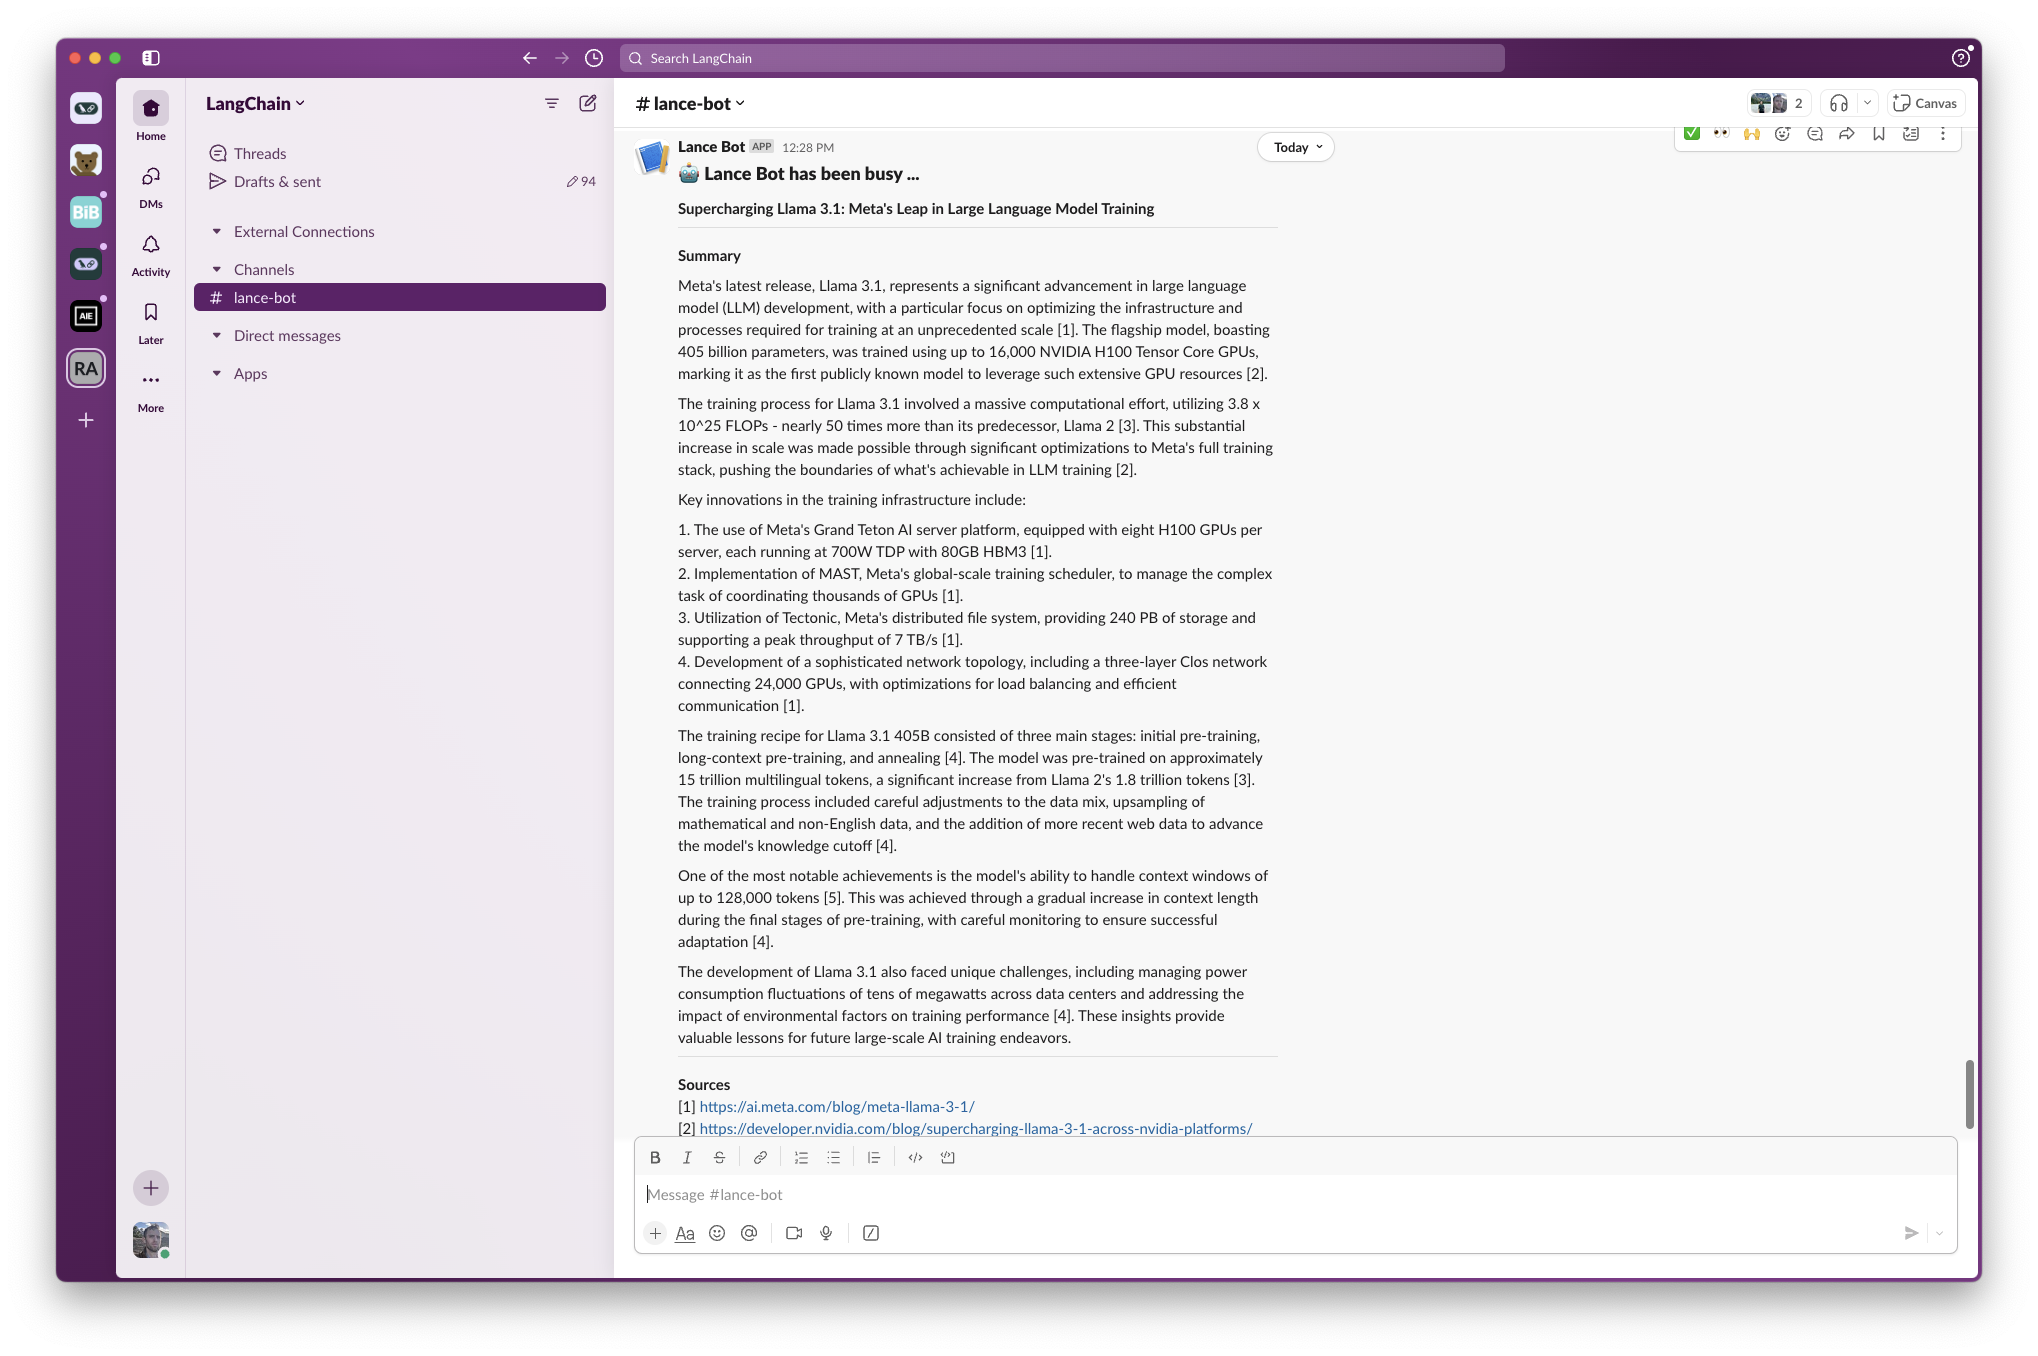